# Compare DM / DM with Nystrom extension / roseland using MNIST data set

## Define functions

### import libraries

In [1]:
%pylab inline

from scipy.spatial.distance import cdist
from scipy.sparse.linalg import svds
from scipy.stats import norm
from math import ceil

from mpl_toolkits.mplot3d import Axes3D
from tensorflow.keras.datasets import mnist

set_printoptions(formatter={'float': lambda x: "{0:0.5f}".format(x)})

Populating the interactive namespace from numpy and matplotlib


### plot results

In [2]:
def plotemb(EMB,EMBlabel,title):
    cmap = cm.jet
    col  = cmap(arange(10)/10)

    fig = plt.figure()
    ax = Axes3D(fig)

    for i in [1,7,9]:
        tmp = argwhere(EMBlabel==i)
        ax.scatter(EMB[tmp,1],EMB[tmp,2],EMB[tmp,3],s=100,c=col[i],label='digit '+str(i), marker=f"${i}$")

    plt.gcf().set_size_inches(8,6)

    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.zaxis.set_ticklabels([])

    fig.suptitle(title+' embedding')
    plt.legend()
    plt.show()

### DM / roseland / DM with Nystrom extension

In [3]:
def MK(X,Y,sigma):
    
    dist = cdist(X,Y)
    
    return exp(-dist**2/sigma)

In [4]:
def DM(X,sigma,dim=6):
    n = X.shape[0]
    
    K = MK(X,X,sigma)
    Q = vstack((arange(n), sum(K,axis=1))).T
    D = diag(1/sqrt(sum(K,axis=1)))
    A = D.dot(K).dot(D)
        
    U,S,V = svds(A,dim)
    
    S = S[::-1]
    U = U[:,::-1]

    for i in range(dim):
        if U[0,i]<0:
            U[:,i] = -U[:,i]
                        
    emb = D.dot(U).dot(diag(S))
        
    return emb, S, Q

In [5]:
def roseland(X,Y,sigma,dim=6):
    n = X.shape[0]

    K = MK(X,Y,sigma)    
    tmp1 = sum(K, axis=0)
    tmp2 = K.dot(tmp1)
    D    = diag(1/sqrt(tmp2))
    A    = D.dot(K)

    U,S,V = svds(A,dim)
    
    S = S[::-1]**2
    U = U[:,::-1]
    
    for i in range(dim):
        if U[0,i]<0:
            U[:,i] = -U[:,i]
                        
    emb = D.dot(U).dot(diag(S))
        
    return emb

In [6]:
def nystrom(X,Y,sample,sigma,dim=6):
    n = X.shape[0]
    
    ind1 = sample
    ind2 = delete(arange(n),ind1)
    ind = hstack((ind1,ind2))

    K = MK(X,Y,sigma) 
    K = K[ind]
    D = diag(1/sqrt(sum(K,axis=1)))
    Dsm = diag(1/sqrt(sum(K,axis=0)))

    Q = D.dot(K).dot(Dsm)
    A = Q[:m]
    B = Q[m:]
    
    uu,ss,vv = svd(A)
    AA = uu.dot(diag(1/sqrt(ss))).dot(vv)
        
    SS = A + AA.dot(B.T).dot(B).dot(AA)
        
    U,S,VV = svds(SS,dim)
    
    S = S[::-1]
    U = U[:,::-1]*sqrt(n)
    for i in range(dim):
        if U[0,i]<0:
            U[:,i] = -U[:,i]
    
    V = Q.dot(AA).dot(U).dot(diag(1/sqrt(S)))

    emb = D.dot(V).dot(diag(S))

    emb2 = zeros((n,dim))
    emb2[ind1] = emb[:m]
    emb2[ind2] = emb[m:]
    
    return emb2

## mnist data set

X: data set, size n

Y: landmark set uniformly chosen from X, size m 

XX: data set 2, size nn (for computing DM)

In [7]:
(trainX, trainY),_ = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [8]:
d1 = argwhere(trainY==1)
d7 = argwhere(trainY==7)
d9 = argwhere(trainY==9)

d1 = d1.reshape(1,size(d1))[0].tolist()
d7 = d7.reshape(1,size(d7))[0].tolist()
d9 = d9.reshape(1,size(d9))[0].tolist()
d  = d1+d7+d9
n  = size(d)

dd1 = d1[:400]
dd7 = d7[:400]
dd9 = d9[:400]
dd  = dd1+dd7+dd9
nn  = size(dd)

tmp     = trainX*(1/256)
X       = tmp[d]
X       = X.reshape(n,X.shape[1]*X.shape[2])
Xlabel  = trainY[d]

m    = round(n**0.45)
Yind = arange(n)[::int(ceil(n/m))][:m]
Y = X[Yind]

XX      = tmp[dd]
XX      = XX.reshape(nn,XX.shape[1]*XX.shape[2])
XXlabel = trainY[dd]

print('number of digit 1 in X: ',size(d1))
print('number of digit 7 in X: ',size(d7))
print('number of digit 9 in X: ',size(d9))
print('\nsize of X, n =',n)
print('size of Y, m =',m)
print('size of XX, nn =',nn)

number of digit 1 in X:  6742
number of digit 7 in X:  6265
number of digit 9 in X:  5949

size of X, n = 18956
size of Y, m = 84
size of XX, nn = 1200


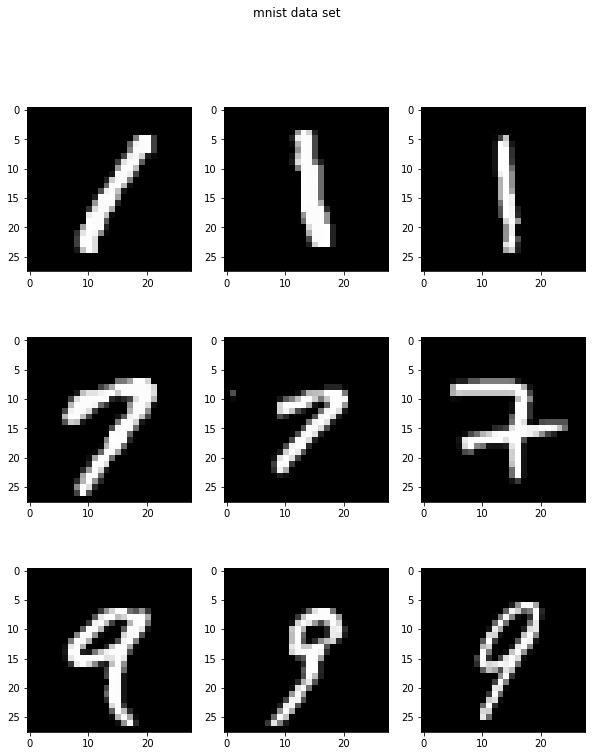

In [9]:
fig,axs = plt.subplots(3,3,figsize=(10,12))
fig.suptitle('mnist data set')

ind1 = d1[:3]
for i in range(3):
    axs[0,i].imshow(trainX[ind1[i]], cmap='gray')

ind7 = d7[:3]
for i in range(3):
    axs[1,i].imshow(trainX[ind7[i]], cmap='gray')

ind9 = d9[:3]
for i in range(3):
    axs[2,i].imshow(trainX[ind9[i]], cmap='gray')

## DM of XX

In [10]:
%%time
sigma = 35

EMBdm, EIGdm, Q = DM(XX,sigma)

CPU times: user 1.58 s, sys: 32.9 ms, total: 1.61 s
Wall time: 2.2 s


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.



eigenvalues:  [1.00000 0.43208 0.27902 0.23526 0.17052 0.14116]


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


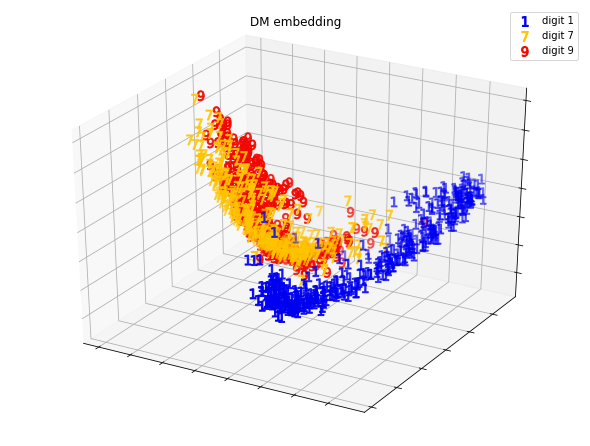

In [11]:
print('\neigenvalues: ',EIGdm)
plotemb(EMBdm,XXlabel,'DM')

## roseland of X

In [12]:
%%time
sigma = 35

EMBr = roseland(X,Y,sigma)

CPU times: user 8.69 s, sys: 1.99 s, total: 10.7 s
Wall time: 7.49 s


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


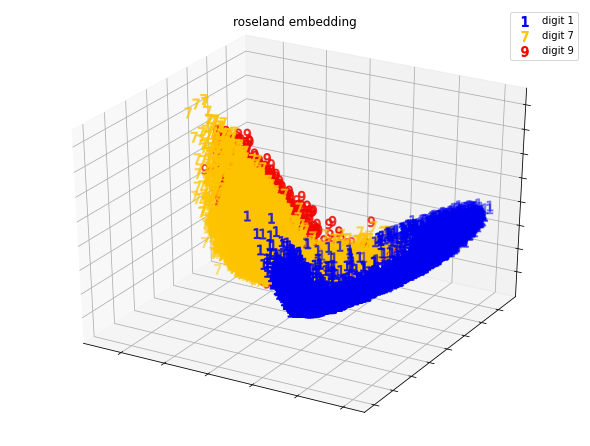

In [13]:
plotemb(EMBr,Xlabel,'roseland')

## DM with Nystrom extension of X

In [14]:
%%time
sigma = 35

EMBn = nystrom(X,Y,Yind,sigma)

CPU times: user 8.74 s, sys: 151 ms, total: 8.89 s
Wall time: 5.3 s


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


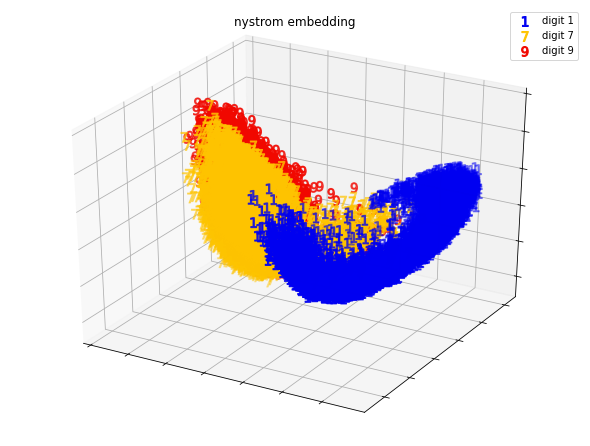

In [15]:
plotemb(EMBn,Xlabel,'nystrom')